终点位置误差: -2.7755575615628914e-15
最终速度初值: 3.141592653589666


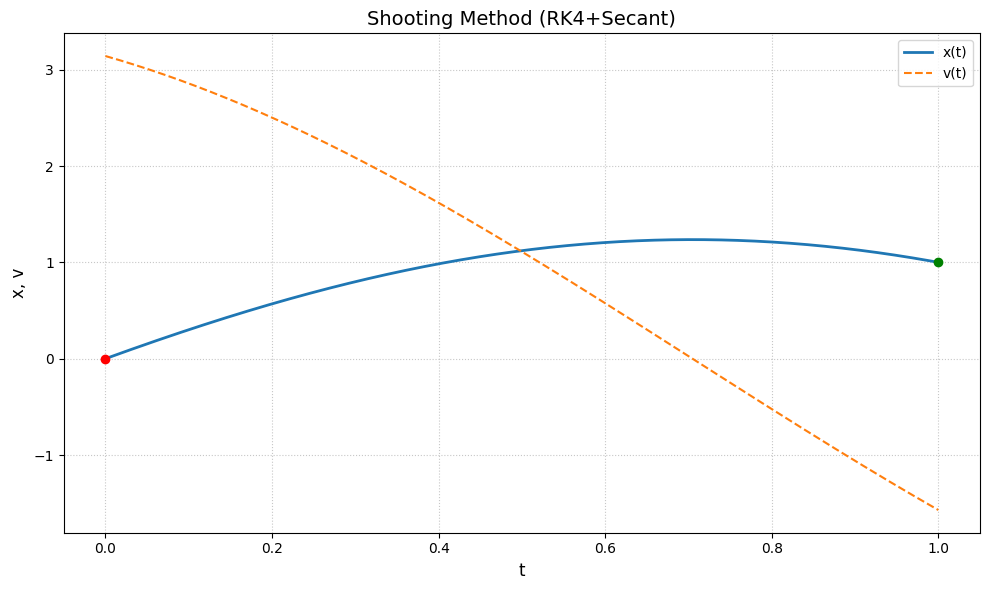

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def func(x):
    """定义二阶微分方程右侧函数（相当于加速度函数）
    方程形式：x'' = -π²/4 * (x + 1)

    参数:
        x -- 当前位置值

    返回:
        加速度值
    """
    return -np.pi**2 / 4 * (x + 1)


def rk4(f, initial_x, target_x, initial_v, num_steps, interval_length):
    """四阶龙格-库塔法求解二阶微分方程

    参数:
        f -- 加速度函数
        initial_x -- 初始位置 x(0)
        target_x -- 目标位置（用于计算误差，实际边界条件）
        initial_v -- 初始速度猜测值
        num_steps -- 离散化步数
        interval_length -- 时间区间长度（t ∈ [0, L]）

    返回:
        t -- 时间序列数组
        x -- 位置序列数组
        v -- 速度序列数组
        delta -- 终点位置误差（x(L) - target_x）
    """
    h = interval_length / num_steps  # 计算步长
    t = np.zeros(num_steps + 1)      # 时间数组
    x = np.zeros(num_steps + 1)      # 位置数组
    v = np.zeros(num_steps + 1)      # 速度数组

    # 初始化初始条件
    t[0] = 0.0
    x[0] = initial_x
    v[0] = initial_v

    # 执行RK4迭代
    for i in range(num_steps):
        # 计算四个斜率（k对应位置，l对应速度）
        k1 = h * v[i]
        l1 = h * f(x[i])

        k2 = h * (v[i] + l1 / 2)
        l2 = h * f(x[i] + k1 / 2)

        k3 = h * (v[i] + l2 / 2)
        l3 = h * f(x[i] + k2 / 2)

        k4 = h * (v[i] + l3)
        l4 = h * f(x[i] + k3)

        # 更新时间和状态量
        t[i + 1] = t[i] + h
        x[i + 1] = x[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        v[i + 1] = v[i] + (l1 + 2 * l2 + 2 * l3 + l4) / 6

    # 计算终点位置与目标位置的差值
    delta = x[-1] - target_x
    return t, x, v, delta


# ================== 全局参数设置 ==================
initial_position = 0.0  # 初始位置 x(0) = 0
target_position = 1.0   # 目标位置 x(1) = 1
num_steps = 1000        # 离散化步数
interval_length = 1.0   # 时间区间长度 L=1


def secant(v0_guess1, v0_guess2, tol):
    """割线法求解边界值问题，寻找合适的初始速度v(0)

    参数:
        v0_guess1 -- 初始速度猜测值1
        v0_guess2 -- 初始速度猜测值2
        tol -- 容差阈值

    返回:
        t -- 最终迭代的时间序列
        x -- 最终迭代的位置序列
        v -- 最终迭代的速度序列
        delta -- 最终的位置误差
    """
    global initial_position, target_position, num_steps, interval_length

    # 执行前两次猜测的RK4计算
    t0, x0, v0, delta0 = rk4(
        func, initial_position, target_position, v0_guess1, num_steps, interval_length
    )
    t1, x1, v1, delta1 = rk4(
        func, initial_position, target_position, v0_guess2, num_steps, interval_length
    )

    # 初始化割线法参数
    current_v0 = v0_guess1  # 前前次猜测值
    current_v1 = v0_guess2  # 前次猜测值

    # 最大迭代100次防止无限循环
    for _ in range(100):
        # 检查是否满足收敛条件
        if abs(delta1) < tol:
            break

        # 计算割线法的分母，防止除零错误
        denominator = delta1 - delta0
        if denominator == 0:
            break

        # 割线法公式更新猜测值
        v_new = (delta1 * current_v0 - delta0 * current_v1) / denominator

        # 计算新猜测值的结果
        t_new, x_new, v_new_vals, delta_new = rk4(
            func, initial_position, target_position, v_new, num_steps, interval_length
        )

        # 更新迭代参数
        current_v0, delta0 = current_v1, delta1  # 前次变为前前次
        current_v1, delta1 = v_new, delta_new    # 新值变为前次

    return t_new, x_new, v_new_vals, delta1


# ================== 主程序执行 ==================
if __name__ == "__main__":
    # 设置初始猜测和收敛阈值
    initial_guess1 = 1.0  # 初始速度猜测值1
    initial_guess2 = 2.0  # 初始速度猜测值2
    tolerance = 1e-6      # 收敛阈值

    # 执行割线法求解
    t_final, x_final, v_final, final_delta = secant(
        initial_guess1, initial_guess2, tolerance
    )

    # 打印最终误差
    print("终点位置误差:", final_delta)
    print("最终速度初值:", v_final[0])

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.plot(t_final, x_final, label="x(t)", linewidth=2)
    plt.plot(t_final, v_final, label="v(t)", linestyle="--")

    plt.xlabel("t", fontsize=12)
    plt.ylabel("x, v", fontsize=12)
    plt.title("Shooting Method (RK4+Secant)", fontsize=14)

    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # 标记关键点
    plt.scatter(0, initial_position, c="red", zorder=5, label="初始位置")
    plt.scatter(interval_length, target_position, c="green", zorder=5, label="目标位置")

    plt.show()